<img src = "https://tdwi.org/~/media/TDWI/TDWI/BITW/bigdata4.jpg">

# <center>BAX-423 Data Design and Representation Final Project

### <center> By Zhongxu (Leo) Pei, Shreya Suranaa, Neha Gupta, Spyros Protoulis 

# Part 1: Relational Data

# Summary of the business problem:

The sales department of ZAGI retail company has decided to create a database that contains the details of
its sales process. After conducting interviews within the company and studying the company
documentation, the database team extracted the following requirements for the future database. ZAGI retail
company sales department database will capture data about the following:

- For each product being sold: product ID (unique), produce name, and price
- For each category of product: category ID (unique) and category name
- For each vendor: vendor ID (unique) and vendor name
- For each customer: customer ID (unique), customer name, and zip code
- For each sales transaction: transaction ID (unique) and date of transaction
- Each product is supplied by exactly one vendor. Each vendor supplies one or more products
- Each product belongs to exactly one category. Each category contains one or more products
- Each sales transaction involves exactly one customer. Each customer can be involved in one or more transactions
- Each product is sold via one more sales transactions. Each sales transaction includes one or more products
- For each instance of a product being sold via a sales transaction, the quantity of sold products is recorded

We will design the data warehouse based on the requirements below and draw the ER-Digram for ZAGI.


# Solution details:

Cardinality constraints - depict how many instances of one entity can be associated with instances of another entity

1.Maximum cardinality
- One (represented by a straight bar: I)
- Many (represented by a crow’s foot symbol)

2.Minimum cardinality (participation)
- Optional (represented by a circular symbol: 0)
- Mandatory (represented by a straight bar: I)



Each piece of equipment to be rented out is an entity with its Serial No. as the unique key.

The date it was made as well as the last inspection date is recorded

The details on make, type, model are stored in a separate entity. On this entity, an ID for the specific model (EquipDetailID) is stored. This is mandatory, no piece of equipment is sold or rented without the details present in the database.

Obviously, it is possible to have multiple pieces of the same model in stock to sell or rent out.

Rentals and sale transactions are stored in separate entities.

Both types of transactions have a similar structure: Transaction ID, Price and Data are recorded.
One sale transaction can only include 1 product (strange, but that’s how it is as per the diagram).

On the contrary, one rental transaction can include multiple products (I wonder if this is by accident)

Because a piece of equipment can either be:
- Sitting in stock
- sold
- rented out, the sale or rental transactions have to be optional

The customer details are stored in our database. Each customer has a unique ID, their name and a category. Obviously, one customer can participate in multiple transactions.

All transactions must involve one, and only one, sales representative. Their details are stored in an entity. 
They have their ID, rank and name recorded. The name is a composite attribute, that breaks down to two attributes, one for First and one for Last name.

A sales rep may (optionally) be a Mentor or a Protege in relation to another rep. This is recorded as a unary relationship. One Mentor can have up to 3 Proteges.

So, a sale or rental transaction has to connect with all of the following entities:
- Equipment (the piece, not the details) 
- Customer
- Sales representative


<img src= "https://github.com/leopei/ER/blob/master/erdplus-diagram.png?raw=true![image.png](attachment:image.png)">

# Summary of the solution and key highlights

Relationship Schema:
* Unary relationship in the SaleRep table, representing a senior sales rep mentoring a protege rep
* Composite key of Sales Rep Name being represented by its components separately in the relationship table: rep First name and rep Last name.

# Key learnings

Relationship Schema:
* Creating FK to show the unary relationship.
* Representing composite variables by its components in the relationship schema table.
* Not including the composite variable in the schema table.

# Part 2: JSON, Data Streaming

# Summary of the business problem:

Meetup.com operates as a website providing membership software, allowing its users to schedule events using a common platform. 

Where are the Meetups? How’s the Data Science Meetup interest in San Francisco? By digging into the RSVP data, we could easily get the answers and insights which can help the platform better understand its users. The first step is to working with the log file and build the analytical data warehouse.

We will work with the API provided by Meetup.com which returns RSVP streming data containing member, group, event, and venue information. We will connect to the data streaming service to receive a limited data feed (1000 json), and parse the JSON data and load it into a SQLite3 database.

Here is our target data schema in our relational database:

<img src= "https://github.com/leopei/ER/blob/master/Database%20ER%20Diagram%20-%20New%20Page.png?raw=true">

# Solution details:

In [3]:
# import libraries
import pandas as pd
import json
import requests
import sqlite3
from urllib.request import urlopen

In [4]:
#request 1000 feed from the streaming API 
r = requests.get('http://stream.meetup.com/2/rsvps', stream=True)
data = []
if r.encoding is None:
    r.encoding = 'utf-8'
counter = 0
for line in r.iter_lines(decode_unicode=True):   
    if line and counter<1000:
        data.append(json.loads(line)) #load fron json
        counter = counter +1
        if counter % 100 ==0:
            print("Done inserting", counter, "records.")
    else:
        break

Done inserting 100 records.
Done inserting 200 records.
Done inserting 300 records.
Done inserting 400 records.
Done inserting 500 records.
Done inserting 600 records.
Done inserting 700 records.
Done inserting 800 records.
Done inserting 900 records.
Done inserting 1000 records.


In [5]:
# show the first rsvp 
data[0]

{'event': {'event_id': '251329714',
  'event_name': 'Hackaton EOS France',
  'event_url': 'https://www.meetup.com/Meetup-EOS-Paris-France/events/251329714/',
  'time': 1530810000000},
 'group': {'group_city': 'Paris',
  'group_country': 'fr',
  'group_id': 28257727,
  'group_lat': 48.86,
  'group_lon': 2.34,
  'group_name': 'Meetup EOS Paris, France',
  'group_topics': [{'topic_name': 'Virtual Currency',
    'urlkey': 'virtual-currency'},
   {'topic_name': 'Blockchain Security', 'urlkey': 'blockchain-security'},
   {'topic_name': 'Blockchain', 'urlkey': 'blockchain'},
   {'topic_name': 'Ethereum', 'urlkey': 'ethereum'},
   {'topic_name': 'Smart Contracts', 'urlkey': 'smart-contracts'},
   {'topic_name': 'Cryptocurrency', 'urlkey': 'cryptocurrency'},
   {'topic_name': 'Digital Currency', 'urlkey': 'digital-currency'},
   {'topic_name': 'Bitcoin', 'urlkey': 'bitcoin'},
   {'topic_name': 'Decentralization', 'urlkey': 'decentralization'},
   {'topic_name': 'Cryptography', 'urlkey': 'crypto

In [6]:
# convert the json/dict file to 3NF table: rsvp, dimension table: venue, event, member, group
def get_table(name):
    lis = []
    for i in data:
        try:
            if i[name] not in lis:
                lis.append(i[name])
        except:
            continue
    return lis

In [7]:
def get_rsvp_table():
    lis = []
    for i in data:
        dic = {}
        try:
            dic["venue_id"] = i['venue']['venue_id']
            dic["event_id"] = i['event']['event_id']
            dic["member_id"]= i['member']['member_id']
            dic["group_id"] = i['group']['group_id']
            dic["rsvp_id"] = i["rsvp_id"]
            dic["guests"] = i["guests"]
            dic["mtime"] = i["mtime"]
            dic["response"] = i["response"]
            lis.append(dic)
        except:
            continue   
    return lis

In [8]:
group = get_table("group")
event = get_table("event")
venue = get_table("venue")
member = get_table("member")
rsvp = get_rsvp_table()

In [9]:
member_df = pd.DataFrame(member)
event_df = pd.DataFrame(event)
rsvp_df = pd.DataFrame(rsvp)
venue_df = pd.DataFrame(venue)
group_df = pd.DataFrame(group)
member_df = member_df[["member_id","member_name","photo"]]
group_df = group_df[["group_id","group_city","group_country","group_lat","group_lon","group_name","group_state","group_urlname"]]

In [10]:
#connect to sqlite3 db
#Use sqlite to create database in memory and create a table
con = sqlite3.connect(":memory:")
cur = con.cursor()

In [11]:
#create the tables in db
cur.execute('''CREATE TABLE member (member_id text primary key, member_name text, photo text)''')
cur.execute('''CREATE TABLE rsvp (event_id text, group_id text, guests text, member_id text, mtime, datetime, response text, rsvp_id text primary key, venue_id, text)''')
cur.execute('''CREATE TABLE venue (lat text, lon text,  venue_id text primary key, venue_name text)''')
cur.execute('''CREATE TABLE groups (group_id text primary key,group_city text,group_country text,group_lat text,group_lon text,group_name text,group_state text,group_urlname text)''')

In [12]:
#store the pandas df into sqlite3 tables
member_df.to_sql("member", con, if_exists="replace")
event_df.to_sql("event", con, if_exists="replace")
rsvp_df.to_sql("rsvp", con, if_exists="replace")
venue_df.to_sql("venue", con, if_exists="replace")
group_df.to_sql("groups", con, if_exists="replace")

In [13]:
#show the table in db
pd.read_sql_query("select * from rsvp limit 10;", con)

,index,event_id,group_id,guests,member_id,mtime,response,rsvp_id,venue_id
0,0,251329714,28257727,0,182524648,1527959095792,yes,1731144401,25366990
1,1,250077668,1685557,0,183165693,1527959095797,no,1731144402,7916842
2,2,dbpmppyxjbmb,15526962,0,255405541,1527959096057,no,1731144404,23133662
3,3,cfztmmyxjbhb,1414289,0,80517402,1527959096122,yes,1731144405,1490527
4,4,hmvmrpyxjbjb,28330616,0,182051362,1527959096354,yes,1731144406,25657054
5,5,251332372,1770300,0,198210601,1527959096379,no,1731144407,11578492
6,6,251237668,1152206,0,143411152,1527959097553,yes,1731144408,19718722
7,7,250295657,27338032,0,243061862,1527959099806,no,1726440223,24111245
8,8,250239641,19575879,0,253122957,1527959100046,yes,1731144412,1528383
9,9,bbqsqpyxjbhb,18567568,0,78839162,1527959100778,no,1731087111,25781564


In [14]:
pd.read_sql_query("select * from member limit 10;", con)

,index,member_id,member_name,photo
0,0,182524648,Alexandre Paris,None
1,1,183165693,Anna,https://secure.meetupstatic.com/photos/member/...
2,2,255405541,Ahsen Sultan Konak,https://secure.meetupstatic.com/photos/member/...
3,3,80517402,Ted Kozlowski,https://secure.meetupstatic.com/photos/member/...
4,4,182051362,LINDA,https://secure.meetupstatic.com/photos/member/...
5,5,198210601,Jessica Stallworth,https://secure.meetupstatic.com/photos/member/...
6,6,251821936,Melanie Davis-Kay,https://secure.meetupstatic.com/photos/member/...
7,7,143411152,David Leahy,https://secure.meetupstatic.com/photos/member/...
8,8,201902887,Patrick Liebig,https://secure.meetupstatic.com/photos/member/...
9,9,219895247,Matt W,https://secure.meetupstatic.com/photos/member/...


In [15]:
pd.read_sql_query("select * from event limit 10;", con)

,index,event_id,event_name,event_url,time
0,0,251329714,Hackaton EOS France,https://www.meetup.com/Meetup-EOS-Paris-France...,1530810000000
1,1,250077668,lunchr: R Lunch,https://www.meetup.com/portland-r-user-group/e...,1528398000000
2,2,dbpmppyxjbmb,North London Stitch Up - Weekly!,https://www.meetup.com/North-London-Stitch-Up/...,1528549200000
3,3,cfztmmyxjbhb,Let's Bowl!,https://www.meetup.com/Olympia-Friends-Meetup/...,1528228800000
4,4,hmvmrpyxjbjb,Celtic Mindfulness including guided meditation...,https://www.meetup.com/Celtic-Mindfulness/even...,1528336800000
5,5,251332372,RfR Morrow Chapter - June Meetup,https://www.meetup.com/Black-Nonbelievers/even...,1528563600000
6,6,nlnnqlyxjbhb,Quite Write: Writing Night!,https://www.meetup.com/Quite-Write/events/2508...,1528237800000
7,7,251237668,Sunday cafe ride - 55miles in new Team jerseys,https://www.meetup.com/tcbicycling/events/2512...,1528034400000
8,8,251062691,"TICA Berlin #10 - Tokens, ICOs, Cryptocurrencies",https://www.meetup.com/TICA-Tokens-ICOs-Crypto...,1531932300000
9,9,251310020,Authentic Montreal Anniversary and Potluck,https://www.meetup.com/Authentic-Montreal/even...,1528664400000


In [16]:
pd.read_sql_query("select * from groups limit 10;", con)

,index,group_id,group_city,group_country,group_lat,group_lon,group_name,group_state,group_urlname
0,0,28257727,Paris,fr,48.86,2.34,"Meetup EOS Paris, France",None,Meetup-EOS-Paris-France
1,1,1685557,Portland,us,45.50,-122.69,Portland R User Group,OR,portland-r-user-group
2,2,15526962,London,gb,51.54,-0.17,North London Stitch Up,None,North-London-Stitch-Up
3,3,1414289,Olympia,us,46.99,-122.87,"Olympia Area Activities, Socializing & Friends",WA,Olympia-Friends-Meetup
4,4,28330616,Petaluma,us,38.24,-122.66,Celtic Mindfulness,CA,Celtic-Mindfulness
5,5,1770300,Atlanta,us,33.80,-84.32,Black Nonbelievers (BN),GA,Black-Nonbelievers
6,6,1643406,Somerville,us,42.38,-71.10,Quite Write,MA,Quite-Write
7,7,1152206,Minneapolis,us,44.95,-93.29,The TC Bicycling Meetup,MN,tcbicycling
8,8,25850006,Berlin,de,52.52,13.38,TICA - Tokens ICOs & Cryptocurrencies Meetup,None,TICA-Tokens-ICOs-Cryptocurrencies-Meetup
9,9,18928546,Montréal,ca,45.65,-73.50,Authentic Montreal,QC,Authentic-Montreal


# Summary of the solution and key highlights

1. Design and set up the OLAP data warehouse using STAR model as we mentioned in the problem statement
2. Build connection with meetup log stream via API
3. Recieve the limited data feed by limiting the number of rows as json format 
4. Filter out the unrelevent records and process the json files to pre-defined 3NF tables
5. Store the 3NF tables into SQLite3 DB

# Key learnings

As more data is generated, it's becoming increasingly important to be able to work with real-time data. Real-time, or streaming, data is generated continuously, and in the case of the stock market, there can be millions of rows generated every hour. Due to size and time constraints, there often isn't a neat dataset that you can analyze — you'll need to either store the data to analyze later, or analyze it in real time, as you get it.

By working on the project, we have the chance to experience the full cycle of development of the stream data engineering pipeline. We also gained the practical experience with different technologies like API, json parser and data modeling.

# Part 3: Text Data 

## Summary of the business problem

The business Problem is to analyze the sentiment from the reviews provided to the company, without reading every review. Here, we have classified into two classes, positive and negative. 

In [103]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import FeatureHasher
from os import listdir
from os.path import isfile, join
import pandas as pd

## Preparing the Data

In [2]:
mypathpos = r'C:\Users\Neha\Downloads\Reviews\train\pos'
mypathneg = r'C:\Users\Neha\Downloads\Reviews\train\neg'
Posreviews = [f for f in listdir(mypathpos) if isfile(join(mypathpos, f))]
Negreviews = [f for f in listdir(mypathneg) if isfile(join(mypathneg, f))]

In [3]:
Posreviewsdf = pd.DataFrame()
Negreviewsdf = pd.DataFrame()

Posreviewsdf['file']=Posreviews

Posreviewsdf['id']= Posreviewsdf['file'].apply(lambda x:x.split('_')[0])

Posreviewsdf['rating']= Posreviewsdf['file'].apply(lambda x:x.split('_')[1].strip('.txt'))

Posreviewsdf['text']=""
for i,f in enumerate(Posreviewsdf['file']):                              
    with open(join(mypathpos, f), 'r') as myfile: Posreviewsdf['text'][i]=myfile.read()

Negreviewsdf['file']=Negreviews
Negreviewsdf['id']= Negreviewsdf['file'].apply(lambda x:x.split('_')[0])
Negreviewsdf['rating']= Negreviewsdf['file'].apply(lambda x:x.split('_')[1].strip('.txt'))


Negreviewsdf['text']=""

for i,f in enumerate(Negreviewsdf['file']):                              
    with open(join(mypathneg, f), 'r') as myfile: Negreviewsdf['text'][i]=myfile.read()

In [25]:
reviewdfs=[Posreviewsdf,Negreviewsdf]
Allreviews=pd.concat(reviewdfs)
Allreviews.head(n=10)
len(Allreviews)

25000

## Bag of Words

Bag of words representation using count vectorizer, a simple count of words per document

In [70]:
vect = CountVectorizer()
vect.fit(Posreviewsdf['text'])
bag_of_words = vect.transform(Posreviewsdf['text'])
bag_of_words_mat=bag_of_words.toarray()
feature_names_m = vect.get_feature_names()
len(feature_names_m)

55739

### TFIDF 

TFIDF representation using TFIDF vectorizer
\begin{equation}
TFIDF(t,d,D) = log(1+f_{{t,d}})  *  {\displaystyle \log \left(1+{\frac {N}{n_{t}}}\right)}
\end{equation}


In [68]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', min_df = 0, stop_words = 'english')
tfidf_matrix =  tf.fit_transform(Posreviewsdf['text'])
feature_names = tf.get_feature_names() 
vocab = feature_names
len(vocab)

55428

In [16]:
tf = TfidfVectorizer(analyzer='word', min_df = 0, stop_words = 'english')
tfidf_matrix =  tf.fit_transform(Posreviewsdf['text'])
for i, feature in enumerate(feature_names): print(i, feature)
print(tfidf_matrix)


  (0, 6769)	0.544982738454
  (0, 23060)	0.279560512647
  (0, 7948)	0.0816176185142
  (0, 9951)	0.0507242076022
  (0, 39624)	0.0879680841492
  (0, 49722)	0.0316578226157
  (0, 38481)	0.10493080468
  (0, 43160)	0.126563073829
  (0, 28746)	0.0389041527211
  (0, 48852)	0.440829837754
  (0, 465)	0.0997937833855
  (0, 54997)	0.0423848430149
  (0, 48854)	0.104138829361
  (0, 38431)	0.105765609801
  (0, 28298)	0.06333638647
  (0, 4873)	0.0552471931789
  (0, 42836)	0.0882413679846
  (0, 9519)	0.0875670191684
  (0, 39929)	0.0656115358452
  (0, 43296)	0.1441329005
  (0, 48075)	0.0850181657653
  (0, 18438)	0.114841114445
  (0, 25233)	0.104138829361
  (0, 47401)	0.175666469927
  (0, 41546)	0.049024767576
  :	:
  (12499, 36040)	0.129288878196
  (12499, 48148)	0.144683481618
  (12499, 18425)	0.109451454038
  (12499, 51802)	0.124394902529
  (12499, 4343)	0.146486987769
  (12499, 9522)	0.131377639588
  (12499, 5554)	0.128133703083
  (12499, 49993)	0.139415943673
  (12499, 27903)	0.121250574111
  (12499

## Preparing for Classification

In [56]:
def binaryclass(string):
    if string in ['6','7','8','9','10']: return 1
    else: return 0

Allreviews['rating']=Allreviews['rating'].apply(lambda x:str(x))

Allreviews['Two_Rating'] = Allreviews[Allreviews.columns[2]].apply(lambda x:binaryclass(x))

Allreviews[Allreviews.columns[2]].head()

Allreviews.head()

In [62]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(Allreviews, test_size=0.2)

x_train = train['text']
y_train = train['Two_Rating']
x_test = test['text']
y_test = test['Two_Rating']

In [71]:
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(50000,100001,10000)
tvec = TfidfVectorizer()

### Fitting the Vectorizer and Model and computing accuracy

To fit the vectorizer and model in a sequence, we have defined a pipeline with these two components. Having a separate function for fitting and collecting resluts lets us change model and vectorizer and get data in the right format for plotting.

In [72]:
def model_fit(pipeline, x_train, y_train, x_test, y_test):
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, train_test_time

### Passing Vectorizer, classifier and getting results

In [81]:
def Res(vectorizer=cvec, n_features=n_features, stop_words='english', ngram_range=(1, 1), classifier=lr):
    resmat = []
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        nfeature_accuracy,tt_time = model_fit(pipeline, x_train, y_train, x_test, y_test)
        resmat.append((n,nfeature_accuracy,tt_time))
    return resmat

In [83]:
result_ut = Res(vectorizer=tvec)
result_bt = Res(vectorizer=tvec,ngram_range=(1, 2))
result_tt = Res(vectorizer=tvec,ngram_range=(1, 3))
result_u = Res(vectorizer=cvec)
result_b = Res(vectorizer=cvec,ngram_range=(1, 2))
result_t = Res(vectorizer=cvec,ngram_range=(1, 3))
result_sw = Res(vectorizer=tvec, ngram_range=(1, 3), stop_words=None)

plot_tt = pd.DataFrame(result_tt,columns=['nfeatures','accuracy','train_test_time'])
plot_bt = pd.DataFrame(result_bt,columns=['nfeatures','accuracy','train_test_time'])
plot_ut = pd.DataFrame(result_ut,columns=['nfeatures','accuracy','train_test_time'])
plot_t = pd.DataFrame(result_t,columns=['nfeatures','accuracy','train_test_time'])
plot_b = pd.DataFrame(result_b,columns=['nfeatures','accuracy','train_test_time'])
plot_u = pd.DataFrame(result_u,columns=['nfeatures','accuracy','train_test_time'])
plot_sw = pd.DataFrame(result_sw,columns=['nfeatures','accuracy','train_test_time'])

Plotting Accuracy for various Vectorizers

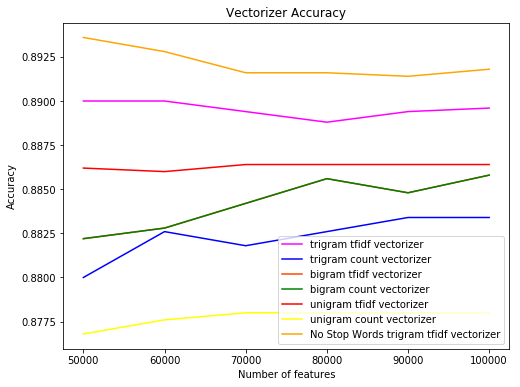

In [85]:
plt.figure(figsize=(8,6))
plt.plot(plot_tt.nfeatures, plot_tt.accuracy,label='trigram tfidf vectorizer',color='magenta')
plt.plot(plot_t.nfeatures, plot_t.accuracy,label='trigram count vectorizer', color='blue')
plt.plot(plot_bt.nfeatures, plot_b.accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(plot_b.nfeatures, plot_b.accuracy,label='bigram count vectorizer',color='green')
plt.plot(plot_ut.nfeatures, plot_ut.accuracy, label='unigram tfidf vectorizer',color='red')
plt.plot(plot_u.nfeatures, plot_u.accuracy, label='unigram count vectorizer',color='yellow')
plt.plot(plot_sw.nfeatures, plot_sw.accuracy, label='No Stop Words trigram tfidf vectorizer',color='orange')
plt.title("Vectorizer Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.legend()

## Adding Lemmatizer

Stemming and Lemmatization means to remove inflection of the words to reduce them to their base form for the purpose of classification and sentiment analysis.

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()
resmat2=[]
x_train2 = x_train.apply(lambda x:stemmer.stem(x.decode('utf-8')))
x_test2=  x_test.apply(lambda x:stemmer.stem(x.decode('utf-8')))
vectorizer = tvec
classifier = lr

for n in range(10000,100001,10000):
        tvec.set_params(stop_words=None, max_features=n, ngram_range=(1,3))
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        sentiment_fit = pipeline.fit(x_train2, y_train)
        y_pred = sentiment_fit.predict(x_test2)
        accuracy = accuracy_score(y_test, y_pred)
        resmat2.append((n,accuracy))

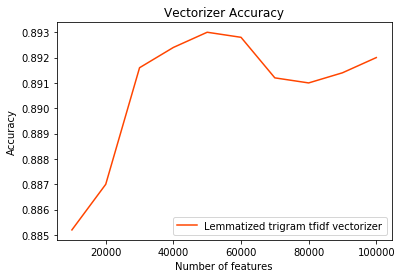

In [100]:
plot_lem = pd.DataFrame(resmat2,columns=['nfeatures','accuracy'])
plt.plot(plot_lem.nfeatures, plot_lem.accuracy,label='Lemmatized trigram tfidf vectorizer',color='orangered')
plt.title("Vectorizer Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.legend()

In [102]:
x_train2.tail()

10479    ludicrous violations of the most basic securit...
1679     i had the (mis)fortune to see this film at a s...
1343     this insipid mini operetta featuring a eddy-mc...
11340    i wasn't really fond of the first "cube" movie...
8632     ** possible spoilers **<br /><br />i like this...
Name: text, dtype: object

## Feature Hasher 

Feature Hashing can be done with very low memory and is scalable to large datasets as there is no need to store a vocabulary dictionary in memory. Also, it is easy to pickle and un-pickle as it holds no state besides the constructor parameters.
However, unlike count vectorizer an inverse can not be generated which makes it impossible to see which features are important.

In [115]:
resmat3 =[]
for n in range(50000,100001,10000):
        h = FeatureHasher(n_features=n,input_type='string')
        f1 = h.transform(x_train)
        f2 = h.transform(x_test)
        sentiment_fit = lr.fit(f1, y_train)
        y_pred = sentiment_fit.predict(f2)
        accuracy = accuracy_score(y_test, y_pred)
        resmat3.append((n,accuracy))


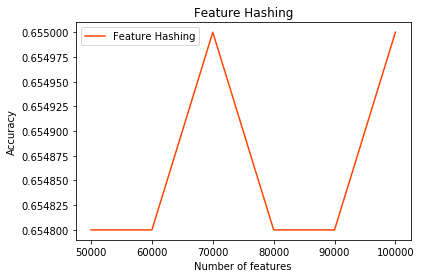

In [116]:
plot_hash = pd.DataFrame(resmat3,columns=['nfeatures','accuracy'])
plt.plot(plot_hash.nfeatures, plot_hash.accuracy,label='Feature Hashing',color='orangered')
plt.title("Feature Hashing")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.legend()

## Summary of the solution and key highlights

We have taken the following steps to classify the reviews into two classes:-

1. Preprocessing the data.
2. Tokenizing and Lemmatizing the data.(reviews text)
3. Vectorization of the text data
4. Training and predicting sentiment
5. Plotting accuracy for number of features for different vectorizers.

## Key learnings

1. Trigram Tfidf gives best accuracy of 89%.
2. The accuracy is higher in trigram TFIDF if stop words are not removed.
3. Stemming helps improve accuracy, but accuracy varies for number of features.
4. Feature Hashing can reduce memory load.